In [1]:
from igraph import Graph
import pandas as pd
import igraph
import networkx as nx

In [2]:
nodes=pd.read_csv('Nodes_df4.csv')
edges=pd.read_csv('Edges_df4.csv')

#### Individuiamo il Giant Component

In [3]:
g_nx=nx.from_pandas_edgelist(edges,source='Source',target='Target')
component_subgraph_list = list(nx.connected_components(g_nx))
largest_component = list(max(component_subgraph_list,key=len))


In [4]:
nodes_list=list(nodes.Id)
new_edges=edges[(edges['Source'].isin(largest_component)) & (edges['Target'].isin(largest_component))]
new_g=Graph.DataFrame(edges=new_edges[['Source','Target']],directed=True)

In [ ]:
#codice per identificare giant component
nodes['Giant_Component']=0

colour=[]
for index in largest_component:
    subset=nodes[nodes.Id==index]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Giant_Component']=1
    else:
        continue

#### Applichiamo leading eigenvector

In [5]:
eigen=new_g.community_leading_eigenvector(2)
eigen.summary()

C:\Users\Eric\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\igraph\__init__.py:1281: RuntimeWarning: This method was developed for undirected graphs at src/community/leading_eigenvector.c:530
  membership, _, q = GraphBase.community_leading_eigenvector(


'Clustering with 3527 elements and 2 clusters'

In [6]:
eigen_nodes=eigen.graph.vs["name"]
df_eigen=pd.DataFrame({'nodes':eigen_nodes,'clusters':eigen._membership})

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

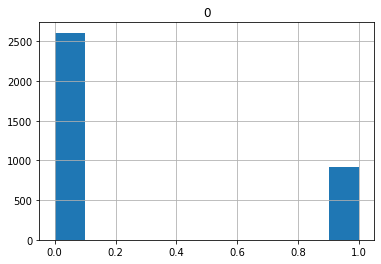

In [7]:
pd.DataFrame(eigen._membership).hist()

In [8]:
nodes['Cluster_eigen']=0

colour=[]
for index, row in df_eigen.iterrows():
    subset=nodes[nodes.Id==int(row['nodes'])]
    if subset.empty == False:
        sub_index=subset.index
        if row['clusters']==0:
            nodes.at[sub_index,'Cluster_eigen']=1
        if row['clusters']==1:
            nodes.at[sub_index,'Cluster_eigen']=2
    else:
        continue

In [524]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)

In [9]:
for i,r in nodes.iterrows():
    if r['Colour']=='#aaaacc':
        nodes.at[i,'Colour']=0
    if r['Colour']=='#007474':
        nodes.at[i,'Colour']=1
    if r['Colour']=='#fb1239':
        nodes.at[i,'Colour']=2

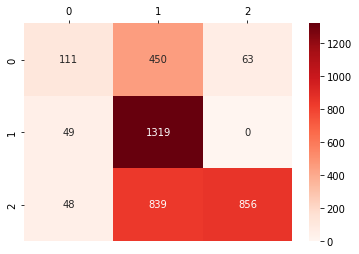

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

conf_mat=confusion_matrix(list(nodes.Colour), list(nodes.Cluster_eigen))

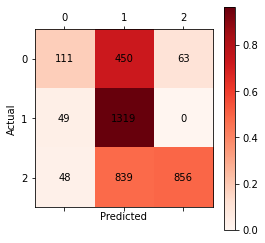

In [93]:
df_conf_norm = pd.DataFrame(conf_mat)
df_conf_norm_r=pd.DataFrame(conf_mat/np.array( [conf_mat.sum(axis=1),conf_mat.sum(axis=1),conf_mat.sum(axis=1)]).T)
plt.matshow(df_conf_norm_r, cmap='Reds')
plt.colorbar()

for (i, j), z in np.ndenumerate(df_conf_norm.to_numpy()):
    plt.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [ ]:
#misure di performance


#### Creazione indice e applicazione k-means

In [340]:
contiguous_nodes_dict={}

for node in nodes.Id:
    lista_target=list(new_edges[new_edges.Source==node]['Target'])
    lista_source=list(new_edges[new_edges.Target==node]['Source'])
    lista_tot=lista_target+lista_source
    if lista_tot != []:
        contiguous_nodes_dict[node]=lista_tot

In [341]:
def Jaccard(nodesA,nodesB):
    intersect = [value for value in nodesA if value in nodesB]
    union=list(set(nodesA+nodesB))
    compute_jaccard=len(intersect)/len(union)
    return compute_jaccard

In [342]:
distance_matrix_j=[[ Jaccard(values_col,values_row) for values_row in contiguous_nodes_dict.values()] for values_col in contiguous_nodes_dict.values()]

In [375]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0,n_init=100,max_iter=1000,algorithm="elkan").fit(distance_matrix_j)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

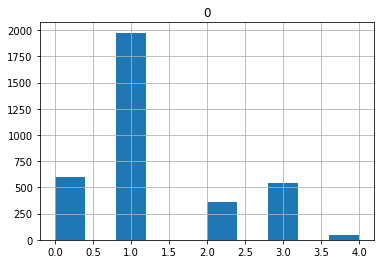

In [376]:
pd.DataFrame(kmeans.labels_).hist()

In [377]:
df_means=pd.DataFrame({'nodes':contiguous_nodes_dict.keys(),'clusters':kmeans.labels_})

In [378]:
nodes['Colour']='#aaaacc'

colour=[]
for index, row in df_means.iterrows():
    subset=nodes[nodes.Id==int(row['nodes'])]
    if subset.empty == False:
        sub_index=subset.index
        if row['clusters']==0:
            nodes.at[sub_index,'Colour']='1'
        if row['clusters']==1:
            nodes.at[sub_index,'Colour']='2'
    else:
        continue

In [379]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)

#### Modularity maximization

In [422]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [427]:
new_G=new_G.to_undirected()

In [435]:
from networkx.algorithms.community import modularity_max
c = list(modularity_max.greedy_modularity_communities(new_G))


In [456]:
nodes['Colour']='#aaaacc'

colours_list=list(range(0,24))
i=0
for community in c:
    colour=[]
    for node in list(community):
        subset=nodes[nodes.Id==int(node)]
        if subset.empty == False:
            sub_index=subset.index
            nodes.at[sub_index,'Colour']=colours_list[i]
        else:
            continue
    i+=1

In [457]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)

#### Girvan-Newman

In [414]:
new_G = nx.from_edgelist([(names[x[0]], names[x[1]])
                      for names in [new_g.vs['name']] # simply a let
                      for x in new_g.get_edgelist()], nx.DiGraph())

In [415]:
new_G=new_G.to_undirected()

In [397]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [398]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [416]:
# find communities in the graph
c = girvan_newman(new_G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

In [408]:
len(node_groups[1])

1449

In [417]:
nodes['Colour']='#aaaacc'

colour=[]
for idx in node_groups[0]:
    subset=nodes[nodes.Id==int(idx)]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Colour']='1'
    else:
        continue

colour=[]
for idx in node_groups[1]:
    subset=nodes[nodes.Id==int(idx)]
    if subset.empty == False:
        sub_index=subset.index
        nodes.at[sub_index,'Colour']='2'
    else:
        continue


In [418]:
nodes.to_csv('Nodes_df4_cluster.csv',index=False)